# 4) Analyze and evaluate optimization output - training protocols

## cell1_211006_3148

This final notebook uses the `runs.pkl` file created in notebook 2 and it analyzes:

- the distance between different feature sets in the feature space
- the distance between different feature sets in the extracellular signals

In [75]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil
from tqdm import tqdm

import bluepyopt as bpopt
import bluepyopt.ephys as ephys
import neuroplotlib as nplt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from pathlib import Path
from pprint import pprint

import multimodalfitting as mf

%matplotlib notebook

In [47]:
# general
base_dir = Path("../../..")


In [3]:
# general
cell_name = "cell1_211006_3148" # "cell1_211006_3148" | "cell1_211011_3436"
model_name = cell_name
ephys_dir = base_dir / "experimental_data" / cell_name / "patch_data"

cell_models_folder = base_dir / "cell_models"
model_folder = cell_models_folder / cell_name

In [4]:
result_dates = [r.name for r in (base_dir / "results").iterdir()]
# use latest results
results_date = max(result_dates)
result_folder = base_dir / "results" / results_date

In [7]:
# select abd (axon_bearing_dendrite) option
abd = False

In [8]:
save_fig = False
fig_folder = Path("../../figures")

if save_fig:
    fig_folder.mkdir(exist_ok=True)

In [9]:
colors_dict = {"soma": "C0",
               "all": "C1",
               "sections": "C2",
               "single": "C3"}
feature_sets = {"soma": "soma",
                "all": "extra",
                "sections": "extra",
                "single": "extra"}
figsize = (10, 7)

# Define cell model and load optimization output

In [10]:
cell = mf.create_experimental_model(model_name=cell_name, abd=abd)
cell_sample = mf.create_experimental_model(model_name=cell_name, release=True, abd=abd)

probe = mf.define_electrode(probe_file=model_folder / "fitting" / "efeatures" / "probe_BPO.json")
param_names = [param.name for param in cell.params.values() if not param.frozen]

In [11]:
print(f"Number of parameters: {len(param_names)} (ABD={abd})")

Number of parameters: 42 (ABD=False)


In [13]:
pkl_file_name = "runs.pkl"

In [14]:
data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")
# set strategy column

results_name = f"opt_results_training_{model_name}"
if abd:
    results_name += "_abd"
else:
    results_name += "_noabd"
results_file = f"{results_name}.pkl"

opt_results_training = None
if (result_folder / results_file).is_file():
    with open(result_folder / results_file, 'rb') as f:
        opt_results_training = pickle.load(f)
else:
    opt_results_all = None

all_responses_file = result_folder / f"all_responses_{model_name}.pkl"

assert all_responses_file.is_file(), "run notebook 3) first"

with open(all_responses_file, "rb") as f:
    opt_results_df = pickle.load(f)

strategies = np.unique(df_model.strategy)

In [ ]:
df_model = df_model.query(f"abd == {abd}")

# Load protocols and experimental features

In [16]:
extra_kwargs = mf.utils.get_extra_kwargs()
extra_kwargs["ms_cut"] = [2, 5]

In [17]:
protocol_for_eap = "IDrest_300"

In [18]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    strategy="all",
    protocols_with_lfp=protocol_for_eap,
    abd=abd,
    **extra_kwargs
)

## Load experimental responses

In [20]:
from bluepyefe.extract import read_recordings, extract_efeatures_at_targets, compute_rheobase,\
    group_efeatures, create_feature_protocol_files, convert_legacy_targets
from bluepyefe.plotting import plot_all_recordings_efeatures

from multimodalfitting.efeatures_extraction import build_wcp_metadata, wcp_reader, get_ecode_targets, \
    ecodes_wcp_timings

In [21]:
# define timings for this experiment
ecodes_cell_timings = {
    "IDthres": {
        'ton': 400,
        'toff': 670
    },
    "firepattern": {
        'ton': 500,
        'toff': 4100
    },
    "IV": {
        'ton': 400,
        'toff': 3400
    },
    "IDrest": {
        'ton': 400,
        'toff': 1750
    },
    "APWaveform": {
        'ton': 350,
        'toff': 400
    },
    "HyperDepol": {
        'ton': 400,
        'toff': 1120,
        'tmid': 850
    },
    "sAHP": {
        'ton': 400,
        'toff': 1325,
        'tmid': 650,
        'tmid2': 875
    },
    "PosCheops": {
        'ton': 1000,
        't1': 9000,
        't2': 10500,
        't3': 14500,
        't4': 16000,
        'toff': 18660
    }
}

In [22]:
if cell_name == "cell1_211006_3148":
    runs = [1, 2, 3, 4, 5]  # run1 --> different rheobase
elif cell_name == "cell1_211011_3436":
    runs = [3, 4, 5, 6]
    
ecode_names = list(ecodes_cell_timings.keys())

files_list = []

for run in runs:
    rep_dict = {}
    for ecode in ecode_names:
        for patch_file in ephys_dir.iterdir():
            if f"run{run}" in patch_file.name and ecode.lower() in patch_file.name:
                rep_dict[ecode] = patch_file
    files_list.append(rep_dict)

In [23]:
files_metadata = build_wcp_metadata(cell_id=cell_name, 
                                    files_list=files_list, 
                                    ecode_timings=ecodes_cell_timings, 
                                    repetition_as_different_cells=False)

In [24]:
cells = read_recordings(
    files_metadata=files_metadata,
    recording_reader=wcp_reader
)

In [25]:
# define target features for different protocols
targets = get_ecode_targets(ecodes_cell_timings)

In [26]:
global_tolerance = 30
for target in targets:
    target["tolerance"] = global_tolerance

In [27]:
if cell_name == "cell1_211006_3148":
    majority = 0.4
else:
    majority = 0.2

In [28]:
compute_rheobase(
    cells, 
    protocols_rheobase=['IDthres'],
    rheobase_strategy="majority",
    rheobase_settings={"majority": majority}
)

/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
print(f"Cell rheobase: {cells[0].rheobase}")

Cell rheobase: 0.11498102761805055


In [30]:
protocols = group_efeatures(cells, targets, use_global_rheobase=True)

In [31]:
protocols_opt = list(eva_extra.fitness_protocols.keys())
print(protocols_opt)

['IDrest_150', 'IDrest_250', 'IDrest_300', 'IV_-100', 'IV_-20', 'APWaveform_290']


In [32]:
all_protocols = list(ecodes_cell_timings.keys())
print(all_protocols)

['IDthres', 'firepattern', 'IV', 'IDrest', 'APWaveform', 'HyperDepol', 'sAHP', 'PosCheops']


### Build BPO response dicts

In [33]:
responses_experimental = []
responses_all = []
num_runs = len(protocols[0].recordings)
for run in range(num_runs):
    print(f"Populating responses for run {run}")
    response_dict = {}
    response_all_dict = {}
    for protocol in protocols:
        for i, rec in enumerate(protocol.recordings):
            if i == run:
                response = bpopt.ephys.responses.TimeVoltageResponse(name=protocol.name,
                                                                     time=rec.t, voltage=rec.voltage)
                response_all_dict[f"{protocol.stimulus_name}.soma.v"] = response
                if protocol.stimulus_name in protocols_opt:
                    response_dict[f"{protocol.stimulus_name}.soma.v"] = response
    responses_experimental.append(response_dict)
    responses_all.append(response_all_dict)

Populating responses for run 0
Populating responses for run 1
Populating responses for run 2
Populating responses for run 3
Populating responses for run 4


In [34]:
responses_to_plot = ["APWaveform_290", "IDrest_250", "firepattern_200", "sAHP_250", "PosCheops_300"]
titles = responses_to_plot

<IPython.core.display.Javascript object>


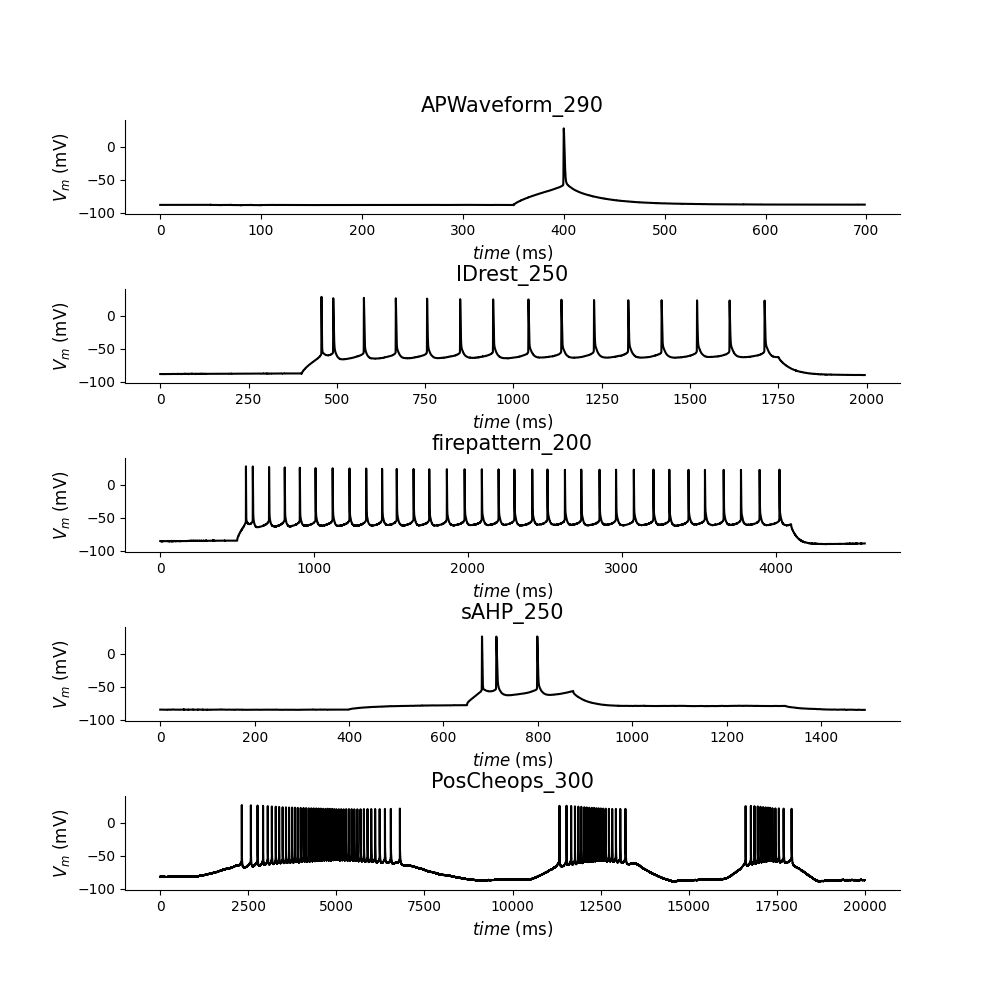

In [35]:
fig_exp_sample = mf.plot_responses(responses_all[2], return_fig=True, 
                                   titles=titles, protocol_names=responses_to_plot,
                                   color="k")

In [48]:
if save_fig:
    fig_exp_sample.savefig(fig_folder / f"fig6up_{cell_name}_sample_response.pdf")
    fig_exp_sample.savefig(fig_folder / f"fig6up_{cell_name}_sample_response.png", dpi=300)  

In [37]:
eap_exp = np.load(model_folder / "fitting" / "efeatures" / "template_BPO.npy") / 1000

<IPython.core.display.Javascript object>


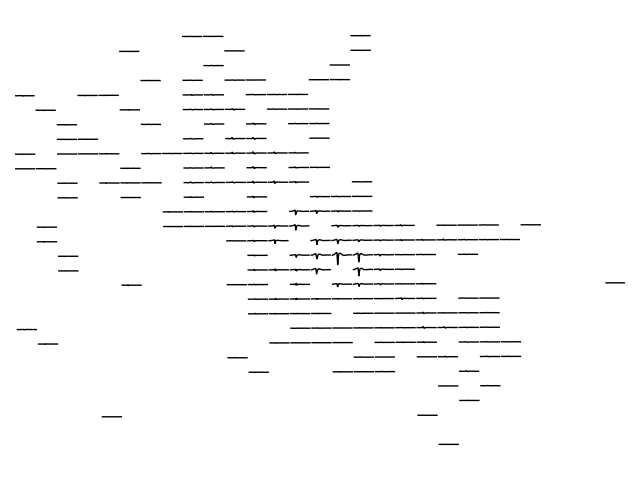

In [38]:
ax = mu.plot_mea_recording(eap_exp, probe)
fig_exp_extra = ax.get_figure()

In [39]:
vscale = np.max(np.abs(eap_exp))

In [ ]:
if save_fig:
    fig_exp_intra.savefig(figure_folder / "exp_intra.png", dpi=300)
    fig_exp_extra.savefig(figure_folder / "exp_extra.png", dpi=300)

# Retrieve and plot training performance

<IPython.core.display.Javascript object>


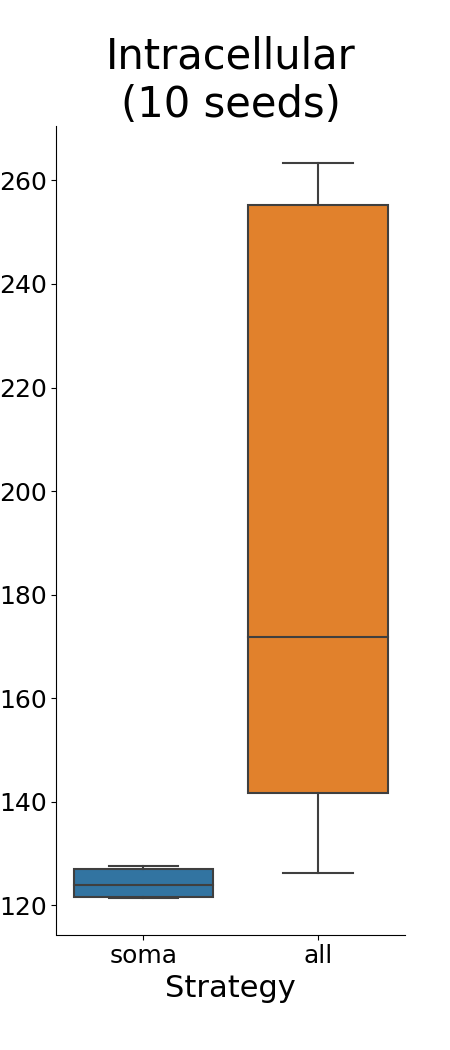

<IPython.core.display.Javascript object>


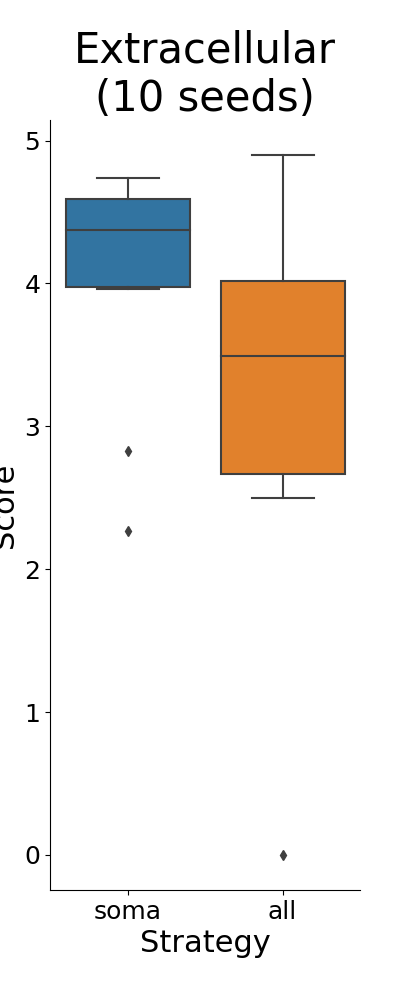

Text(0.5, 1.0, 'Extracellular\n(10 seeds)')

In [62]:
selected_strategies = ["soma", "all"]

opt_results_df_abd = opt_results_df.query(f"abd == {abd}")

colors = [colors_dict[strat] for strat in order]
fig_intra_seeds, ax = plt.subplots(figsize=(4.5, 10.5))
sns.boxplot(data=opt_results_df_abd, x="strategy", y="intra_score", 
            order=selected_strategies, showfliers=False,  ax=ax, palette=colors)
ax.set_xlabel("Strategy", fontsize=22)
ax.set_ylabel("Score", fontsize=22)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_title("Intracellular\n(10 seeds)", fontsize=30)

fig_extra_seeds, ax = plt.subplots(figsize=(4, 10))
sns.boxplot(data=opt_results_df_abd, x="strategy", y="extra_score",
            showfliers=True,  order=selected_strategies, palette=colors)
ax.set_xlabel("Strategy", fontsize=22)
ax.set_ylabel("Score", fontsize=22)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_title("Extracellular\n(10 seeds)", fontsize=30)


In [50]:
fig_intra_seeds.savefig(fig_folder / f"fig7A1_{cell_name}_intra.pdf", 
                        transparent=True, bbox_inches="tight")
fig_extra_seeds.savefig(fig_folder / f"fig7A2_{cell_name}_extra.pdf", 
                        transparent=True, bbox_inches="tight")

## Compute validation responses for best solutions

In [64]:
# best responses are the solutions that minimize intra_scores
best_intras = opt_results_df_abd.loc[opt_results_df_abd.groupby("strategy")["intra_score"].idxmin()]

opt_results_best = {}
for idx, row in best_intras.iterrows():

    strategy = row["strategy"]
    seed = row["seed"]
    abd = row.abd
    eap = row.eap

    opt_results_best[strategy] = {}

    print("Strategy", strategy, "best seed", seed, "abd", abd)
    responses = row["responses"]
    opt_results_best[strategy]["best_seed"] = row.seed
    opt_results_best[strategy]["best_responses"] = row.responses
    opt_results_best[strategy]["best_eap"] = row.eap
    opt_results_best[strategy]["best_params"] = row.params
    eap_exp_norm = eap_exp / np.ptp(np.abs(eap_exp), 1, keepdims=True)
    eap_norm = eap / np.ptp(np.abs(eap), 1, keepdims=True)
    eap_dist = np.sum(np.abs(eap_exp_norm.ravel() - eap_norm.ravel()))
    opt_results_best[strategy]["best_eap_dist"] = eap_dist

Strategy all best seed 9 abd False
Strategy sections best seed 9 abd False
Strategy single best seed 10 abd False
Strategy soma best seed 5 abd False


In [68]:
pickle.dump?

In [69]:
best_responses_filename = result_folder / f"best_responses_{model_name}.pkl"
with open(best_responses_filename, "wb") as f:
    pickle.dump(opt_results_best, f)

In [65]:
protocol_for_eap = "firepattern_200"
protocols_to_exclude = ["IV", "APWaveform", "IDrest"]

eva_extra_testing = mf.create_evaluator(
    model_name=model_name,
    strategy="all",
    protocols_with_lfp=protocol_for_eap,
    all_protocols=True,
    exclude_protocols=protocols_to_exclude,
    **extra_kwargs
)

print(f"All test features --> num features {len(eva_extra_testing.fitness_calculator.objectives)}")

All test features --> num features 107


In [100]:
opt_results_validation = {}

for strategy in selected_strategies:

    print(f"Simulating best '{strategy}' -- seed: {opt_results_best[strategy]['best_seed']}")
    t_start = time.time()
    responses = eva_extra_testing.run_protocols(
        eva_extra_testing.fitness_protocols.values(), 
        param_values=opt_results_best[strategy]["best_params"]
    )
    print(f"Simulated responses in {np.round(time.time() - t_start, 2)} s")

    eap = mf.utils.calculate_eap(
        responses=responses, protocols=eva_extra_testing.fitness_protocols,
        protocol_name=protocol_for_eap, align_extra=True, **extra_kwargs)

    opt_results_validation[strategy] = {
        "responses": responses,
        "eap": eap,
        "features": eva_extra_testing.fitness_calculator.calculate_scores(responses),
        "params": opt_results_best[strategy]["best_params"]
    }

# pickle.dump(opt_results_test, open(f"responses_testing_{model_name}_{abd}.pkl", "wb"))

Simulating best 'soma' -- seed: 5
Simulated responses in 570.73 s
Simulating best 'all' -- seed: 9
Simulated responses in 272.51 s


In [102]:
val_responses_filename = result_folder / f"validation_responses_{model_name}.pkl"
with open(val_responses_filename, "wb") as f:
    pickle.dump(opt_results_validation, f)

<IPython.core.display.Javascript object>


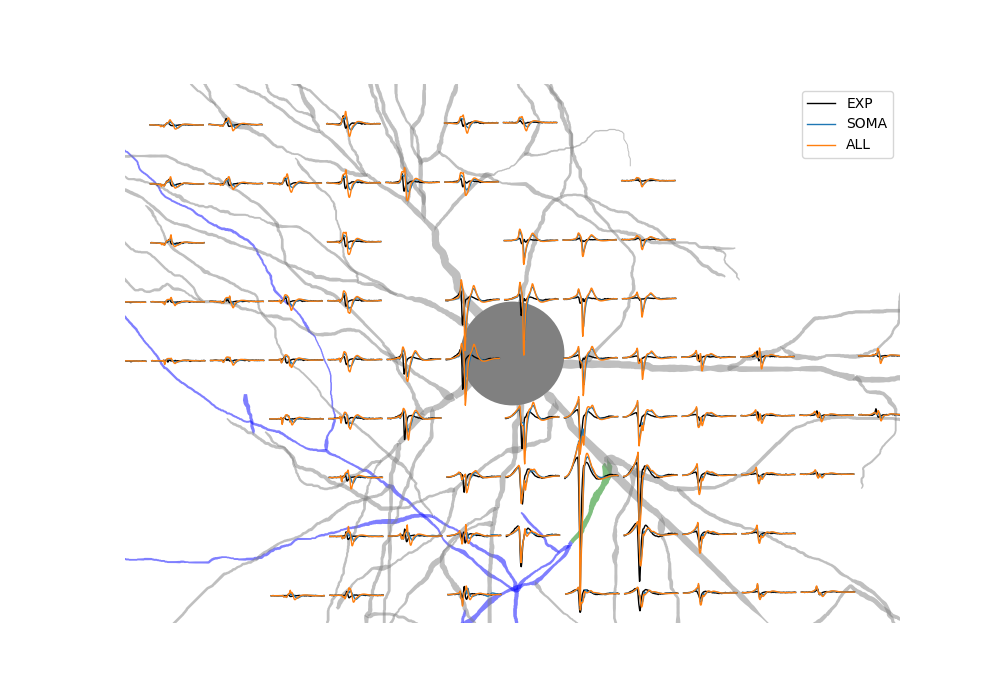

/tmp/ipykernel_1617734/3801236372.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(xy=(0, 0), width=30, height=30,


In [97]:
eap_exp = np.load(model_folder / "fitting" / "efeatures" / "template_BPO.npy") / 1000
vscale = 0.8 * np.max(np.abs(eap_exp))

fig_extra, ax_extra = plt.subplots(figsize=figsize)

mf.plot_cell(
    eva_extra.cell_model, eva_extra.sim,
    color="gray",
    color_ais="g",
    color_axon="b",
    detailed=True,
    param_values=opt_results_best["all"]["best_params"],
    ax=ax_extra, 
    exclude_sections=["soma"],
    alpha=0.5,
    lw=0.5
)
ellipse = Ellipse(xy=(0, 0), width=30, height=30, 
                  edgecolor="grey", color="grey", lw=2)
ax_extra.add_patch(ellipse)

ax_extra = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1, ax=ax_extra)
ax_extra.get_lines()[-1].set_label("EXP")

ax_extra = mu.plot_mea_recording(opt_results_validation["soma"]["eap"], probe, ax=ax_extra, vscale=vscale, 
                                 colors=colors_dict["soma"], lw=1)
ax_extra.get_lines()[-1].set_label("SOMA")

ax_extra = mu.plot_mea_recording(opt_results_validation["all"]["eap"], probe, ax=ax_extra, vscale=vscale, 
                                 colors=colors_dict["all"], lw=1)
ax_extra.get_lines()[-1].set_label("ALL")

ax_extra.set_xlim(-110, 110)
ax_extra.set_ylim(-80, 80)
ax_extra.legend()

In [ ]:
fig_extra.savefig(fig_folder / f"fig7bottom-center_{cell_name}_responses_extra.pdf", 
                  transparent=True, bbox_inches="tight")

<IPython.core.display.Javascript object>


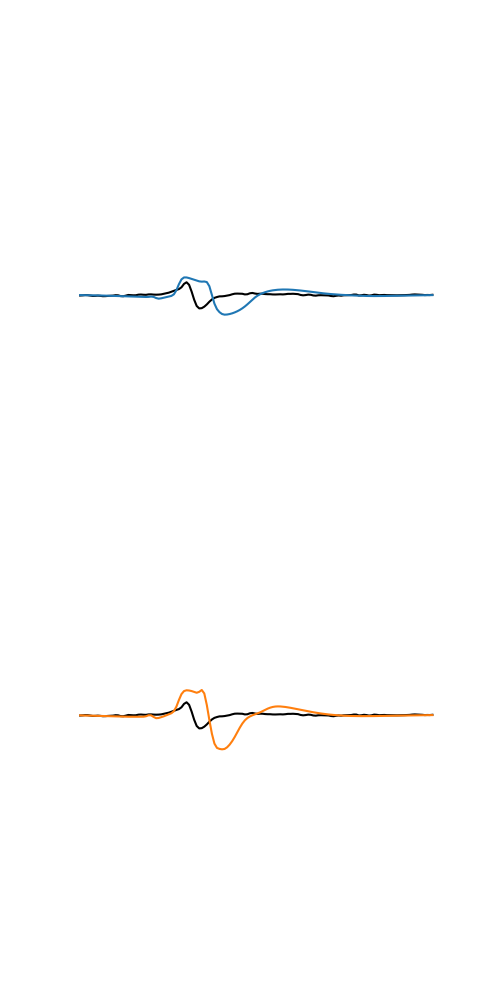

<IPython.core.display.Javascript object>


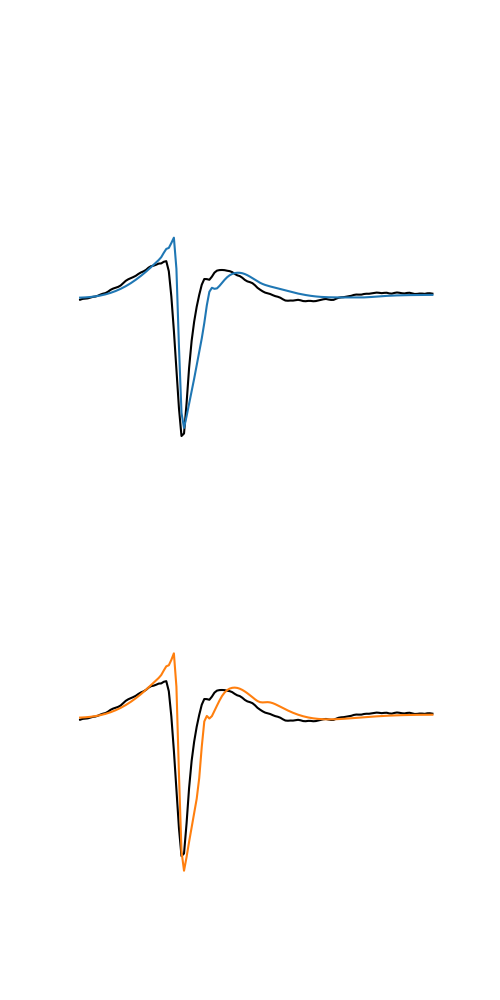

In [93]:
# make zoomed in
el0 = [-50, 28, 0]
el1 = [38, -38, 0]

figs_zoom = []
for el in [el0, el1]:
    fig_zoom, axs = plt.subplots(nrows=2, figsize=(5, 10))
    elec_idx = np.argmin([np.linalg.norm(el - p) for p in probe.positions])
    axs[0].plot(eap_exp[elec_idx], color="k")
    axs[0].plot(opt_results_validation["soma"]["eap"][elec_idx], color=colors_dict["soma"])    
    axs[1].plot(eap_exp[elec_idx], color="k")    
    axs[1].plot(opt_results_validation["all"]["eap"][elec_idx], color=colors_dict["all"])
    for ax in axs:
        ax.axis("off")
        ax.set_ylim(-0.2, 0.2)
    figs_zoom.append(fig_zoom)

In [95]:
figs_zoom[0].savefig(fig_folder / f"fig7bottom-left_{cell_name}_responses_extra.pdf", 
                     transparent=True, bbox_inches="tight")
figs_zoom[1].savefig(fig_folder / f"fig7bottom-right_{cell_name}_responses_extra.pdf", 
                     transparent=True, bbox_inches="tight")